# Decision Tree and Random Forest from Scratch

This notebook implements a **Decision Tree classifier** and a **Random Forest classifier** from scratch using Python.  
We'll use the **Breast Cancer dataset** from `sklearn.datasets` and demonstrate training, hyperparameter tuning, evaluation, and visualization.


Import Libraries

In [2]:
import numpy as np
from numpy import log2 ,sqrt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.tree as sktree
import graphviz

# Decision Tree Node Class

The `Node` class represents a single node in the decision tree.  
Attributes:
- `feature`: index of feature used for split
- `threshold`: value to split on
- `left` / `right`: child nodes
- `value`: class label if leaf node


In [3]:
# Decision Tree Node Class
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature 
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value 

# Decision Tree Class

`DecisionTree` implements a decision tree classifier using **information gain (entropy)** as the splitting criterion.  

Parameters:
- `max_depth`: maximum depth of tree
- `min_samples_split`: minimum samples required to split a node


In [4]:
class DecisionTree:
    def __init__(self, max_depth=5, min_samples_split=2):
        self.max_depth = max_depth # Maximum depth of the tree
        self.min_samples_split = min_samples_split # Minimum samples required to split
        self.root = None # Root node of the tree
        self.n_features= None # Number of features in the dataset
        self.feature_importances = None # Feature importance scores

# Calculate entropy of a label array
    @staticmethod
    def entropy(y):
        if len(y) == 0:
            return 0.0
        counts = {}
        for label in y:
            counts[label] = counts.get(label, 0) + 1 # Count occurrences of each class
        
        total = len(y)
        H = 0.0
        
        for c in counts.values(): # Calculate entropy
            p = c / total
            H -= p * log2(p)
        
        return H  

# Calculate information gain from a split
    @staticmethod
    def information_gain(parent_y, left_y, right_y):
        n = len(parent_y)
        if n == 0:
            return 0.0
        H_parent = DecisionTree.entropy(parent_y) # Entropy before split
        n_left = len(left_y) # Entropy after split
        n_right = len(right_y) # Entropy after split
        if n_left == 0 or n_right == 0: # No split occurred
            return 0.0 
        H_children = (n_left/n) * DecisionTree.entropy(left_y) + (n_right/n) * DecisionTree.entropy(right_y) # Weighted entropy after split
        return H_parent - H_children # Information gain is the reduction in entropy

# Find the best feature and threshold to split on
    def _best_split(self, X, y):
        n_samples, n_features = X.shape
        best_gain = -1
        best_feat = None
        best_thresh = None
        best_left_idx = None
        best_right_idx = None
        # Iterate over all features and possible thresholds
        for feature in range(n_features):
            vals = np.unique(X[:, feature]) # Unique values for the feature
            if vals.shape[0] == 1:
                continue
            thresholds = (vals[:-1] + vals[1:]) / 2.0 # Midpoints between unique values
            # Evaluate each threshold
            for thresh in thresholds: 
                left_idx = np.where(X[:, feature] <= thresh)[0]
                right_idx = np.where(X[:, feature] > thresh)[0]
                gain = self.information_gain(y, y[left_idx], y[right_idx])
                # Update best split if gain is higher
                if gain > best_gain:
                    best_gain = gain
                    best_feat = feature
                    best_thresh = thresh
                    best_left_idx = left_idx
                    best_right_idx = right_idx

# Return the best feature, threshold, gain, and indices for left/right splits
        if best_gain <= 0:
            return None, None, 0.0, None, None
        return best_feat, best_thresh, best_gain, best_left_idx, best_right_idx

# Determine the majority class in a label array
    def _majority_class(self, y):
        counts = {}
        for label in y:
            counts[label] = counts.get(label, 0) + 1 # Count occurrences of each class
        majority = max(counts, key=counts.get)
        return majority

# Recursively build the decision tree
    def _build(self, X, y, depth):
        if len(y) == 0: # No samples left
            return Node(value=None)
        if len(np.unique(y)) == 1: # All samples belong to the same class
            return Node(value=self._majority_class(y))
        if depth >= self.max_depth or len(y) < self.min_samples_split: # Stopping criteria 
            return Node(value=self._majority_class(y))

# Find the best split
        feat, thresh, gain, left_idx, right_idx = self._best_split(X, y)
        if feat is None or gain <= 0 or left_idx is None or right_idx is None:
            return Node(value=self._majority_class(y))
        self.feature_importances[feat] += gain

# Recursively build left and right subtrees
        left = self._build(X[left_idx], y[left_idx], depth + 1)
        right = self._build(X[right_idx], y[right_idx], depth + 1)
        return Node(feature=feat, threshold=thresh, left=left, right=right)

# Fit the decision tree to the data
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self.n_features = X.shape[1]
        self.feature_importances = np.zeros(self.n_features, dtype=float)
        self.root = self._build(X, y, depth=0)
        total = self.feature_importances.sum()
        if total > 0:
            self.feature_importances= self.feature_importances/ total

# Predict the class for a single sample
    def _predict_one(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self._predict_one(x, node.left)
        else:
            return self._predict_one(x, node.right)

# Predict classes for multiple samples
    def predict(self, X):
        X = np.array(X)
        preds = [self._predict_one(x, self.root) for x in X]
        return np.array(preds)
# Score the model accuracy
    def score(self, X, y):
        preds = self.predict(X)
        return np.mean(preds == y)

#  Load Dataset and Split Data
We split into **train**, **validation**, and **test** sets.


In [5]:
# Load dataset and split into train, validation, and test sets
data = load_breast_cancer()
X = data.data #data features
y = data.target #data labels
feature_names = data.feature_names #data feature names
class_names = data.target_names #data class names

# Split data into training+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

# Split training+validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, stratify=y_train_val, random_state=42
) 

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (397, 30), Val: (86, 30), Test: (86, 30)


#  Hyperparameter Tuning for Decision Tree

We test different `max_depth` and `min_samples_split` to find the best validation accuracy.


In [6]:
max_depth_values = [2, 4, 6, 8, 10] 
min_samples_split_values = [2, 5, 10]

best_val_acc = 0
best_params = None
results = []

# Hyperparameter tuning loop
for max_depth in max_depth_values:
    for min_samples_split in min_samples_split_values:
        tree = DecisionTree(max_depth=max_depth, min_samples_split=min_samples_split)
        tree.fit(X_train, y_train)
        val_acc = tree.score(X_val, y_val)
        train_acc = tree.score(X_train, y_train)
        results.append((max_depth, min_samples_split, train_acc, val_acc))
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = (max_depth, min_samples_split)

# Display results
results_df = pd.DataFrame(results, columns=['max_depth', 'min_samples_split', 'train_acc', 'val_acc'])
print("Hyperparameter Tuning Results:\n", results_df)
print(f"Best Hyperparameters: max_depth={best_params[0]}, min_samples_split={best_params[1]}")


Hyperparameter Tuning Results:
     max_depth  min_samples_split  train_acc   val_acc
0           2                  2   0.926952  0.930233
1           2                  5   0.926952  0.930233
2           2                 10   0.926952  0.930233
3           4                  2   0.987406  0.965116
4           4                  5   0.982368  0.965116
5           4                 10   0.977330  0.976744
6           6                  2   1.000000  0.965116
7           6                  5   0.992443  0.965116
8           6                 10   0.982368  0.976744
9           8                  2   1.000000  0.965116
10          8                  5   0.992443  0.965116
11          8                 10   0.982368  0.976744
12         10                  2   1.000000  0.965116
13         10                  5   0.992443  0.965116
14         10                 10   0.982368  0.976744
Best Hyperparameters: max_depth=4, min_samples_split=10


Decision Tree Validation Accuracy Heatmap


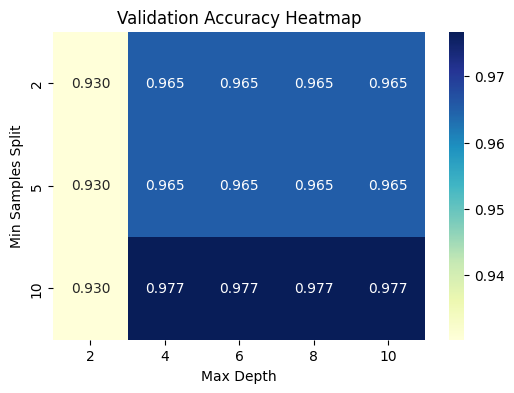

In [7]:
# Visualize validation accuracy heatmap
import seaborn as sns
plt.figure(figsize=(6,4))

heatmap_data = results_df.pivot(index="min_samples_split", columns="max_depth", values="val_acc")

sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Validation Accuracy Heatmap")
plt.xlabel("Max Depth")
plt.ylabel("Min Samples Split")
plt.show()


## Train Final Decision Tree

Train using **best hyperparameters** on combined training + validation sets.

In [8]:
# Train final model with best hyperparameters on combined training and validation sets
X_train_final = np.vstack([X_train, X_val])
y_train_final = np.hstack([y_train, y_val])

best_tree = DecisionTree(max_depth=best_params[0], min_samples_split=best_params[1])
best_tree.fit(X_train_final, y_train_final)


## Evaluation Functions

Define accuracy, precision, recall, F1-score, and confusion matrix functions.

In [9]:
# Evaluate on test set
def confusion_matrix(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([[TN, FP],
                     [FN, TP]])

# Calculate accuracy, precision, recall, and F1-score
def accuracy_score(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

def precision_score(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    if TP + FP == 0:
        return 0.0
    return TP / (TP + FP)

def recall_score(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    if TP + FN == 0:
        return 0.0
    return TP / (TP + FN)

def f1_score(y_true, y_pred):
    p = precision_score(y_true, y_pred)
    r = recall_score(y_true, y_pred)
    if p + r == 0:
        return 0.0
    return 2 * (p * r) / (p + r)



Evaluate Decision Tree on Test Set

In [10]:
# Make predictions on the test set
y_pred = best_tree.predict(X_test)
# Calculate metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("\nTest Set Performance:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")
print("Confusion Matrix:\n", cm)



Test Set Performance:
Accuracy: 0.9419
Precision: 1.0000
Recall: 0.9074
F1-score: 0.9515
Confusion Matrix:
 [[32  0]
 [ 5 49]]


In [11]:
# Calculate precision, recall, and F1-score for each class
def precision_recall_f1_for_classes(y_true, y_pred):
    classes = np.unique(y_true)
    metrics = {}
    for cls in classes:
        TP = np.sum((y_true == cls) & (y_pred == cls))
        FP = np.sum((y_true != cls) & (y_pred == cls))
        FN = np.sum((y_true == cls) & (y_pred != cls))
        precision = TP / (TP + FP) if TP + FP > 0 else 0
        recall = TP / (TP + FN) if TP + FN > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
        metrics[cls] = {"Precision": precision, "Recall": recall, "F1": f1}
    return metrics


Visualize Confusion Matrix


Metrics per class:
Class 0: Precision=0.8649, Recall=1.0000, F1=0.9275
Class 1: Precision=1.0000, Recall=0.9074, F1=0.9515


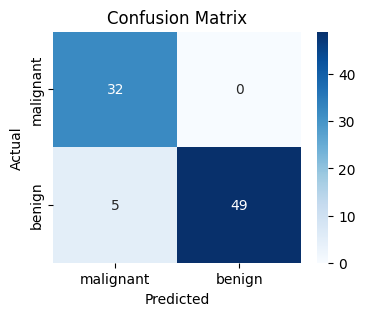

In [12]:

metrics_per_class = precision_recall_f1_for_classes(y_test, y_pred)
print("\nMetrics per class:")
for cls, vals in metrics_per_class.items():
    print(f"Class {cls}: Precision={vals['Precision']:.4f}, Recall={vals['Recall']:.4f}, F1={vals['F1']:.4f}")

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


 Feature Importance


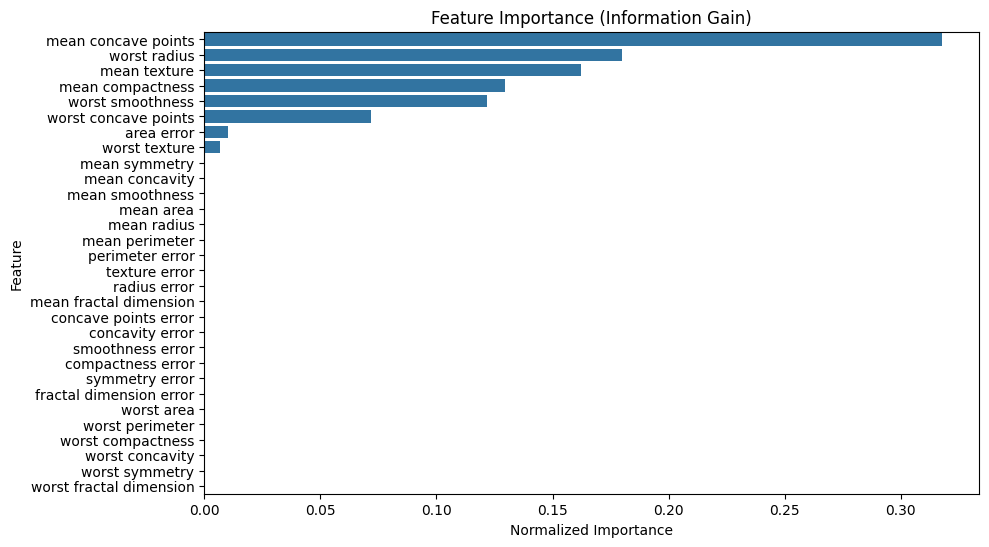

In [13]:
# Visualize feature importances
importances = best_tree.feature_importances
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)


plt.figure(figsize=(10,6))
sns.barplot(x="importance", y="feature", data=feature_importance_df)
plt.title("Feature Importance (Information Gain)")
plt.xlabel("Normalized Importance")
plt.ylabel("Feature")
plt.show()


    max_depth  min_samples_split  train_acc   val_acc
0           2                  2   0.926952  0.930233
3           4                  2   0.987406  0.965116
6           6                  2   1.000000  0.965116
9           8                  2   1.000000  0.965116
12         10                  2   1.000000  0.965116
    max_depth  min_samples_split  train_acc   val_acc
1           2                  5   0.926952  0.930233
4           4                  5   0.982368  0.965116
7           6                  5   0.992443  0.965116
10          8                  5   0.992443  0.965116
13         10                  5   0.992443  0.965116
    max_depth  min_samples_split  train_acc   val_acc
2           2                 10   0.926952  0.930233
5           4                 10   0.977330  0.976744
8           6                 10   0.982368  0.976744
11          8                 10   0.982368  0.976744
14         10                 10   0.982368  0.976744


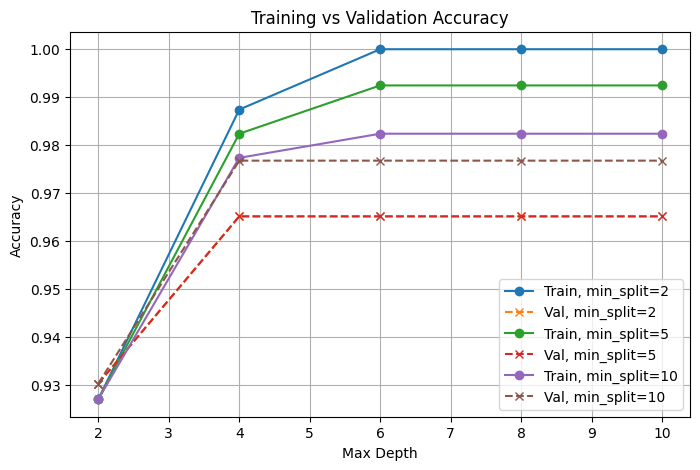

In [14]:
# Plot training and validation accuracy vs max_depth for different min_samples_split
plt.figure(figsize=(8,5))
for min_split in min_samples_split_values:
    subset = results_df[results_df['min_samples_split'] == min_split]
    print(subset)
    plt.plot(subset['max_depth'], subset['train_acc'], marker='o', label=f"Train, min_split={min_split}")
    plt.plot(subset['max_depth'], subset['val_acc'], marker='x', linestyle='--', label=f"Val, min_split={min_split}")

plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
# Visualize the decision tree structure
def print_tree(node, feature_names, depth=0):
    indent = "  " * depth
    if node.value is not None:
        print(f"{indent}Leaf: Class={node.value}")
        return
    feature = feature_names[node.feature]
    print(f"{indent}[{feature} <= {node.threshold:.2f}]")
    print(f"{indent}--> True:")
    print_tree(node.left, feature_names, depth + 1)
    print(f"{indent}--> False:")
    print_tree(node.right, feature_names, depth + 1)

print_tree(best_tree.root, feature_names)


[worst radius <= 16.80]
--> True:
  [worst concave points <= 0.14]
  --> True:
    [area error <= 38.61]
    --> True:
      [worst texture <= 29.98]
      --> True:
        Leaf: Class=1
      --> False:
        Leaf: Class=1
    --> False:
      [mean compactness <= 0.06]
      --> True:
        Leaf: Class=0
      --> False:
        Leaf: Class=1
  --> False:
    [mean texture <= 20.30]
    --> True:
      [worst smoothness <= 0.14]
      --> True:
        Leaf: Class=1
      --> False:
        Leaf: Class=0
    --> False:
      Leaf: Class=0
--> False:
  [mean texture <= 15.82]
  --> True:
    [mean concave points <= 0.07]
    --> True:
      Leaf: Class=1
    --> False:
      Leaf: Class=0
  --> False:
    [worst smoothness <= 0.09]
    --> True:
      Leaf: Class=1
    --> False:
      Leaf: Class=0


In [16]:
# Visualize the decision tree using Graphviz
from graphviz import Digraph

def plot_tree_graphviz(node, feature_names, dot=None, parent=None, edge_label=""):
    if dot is None:
        dot = Digraph()
        dot.node(name="root", label="Root")
        parent = "root"
    
    if node.value is not None:
        node_id = str(id(node))
        dot.node(node_id, label=f"Class={node.value}", shape="box")
        dot.edge(parent, node_id, label=edge_label)
        return dot
    
    node_id = str(id(node))
    dot.node(node_id, label=f"{feature_names[node.feature]} <= {node.threshold:.2f}")
    dot.edge(parent, node_id, label=edge_label)
    
    plot_tree_graphviz(node.left, feature_names, dot, node_id, "True")
    plot_tree_graphviz(node.right, feature_names, dot, node_id, "False")
    
    return dot


In [17]:
# Visualize the decision tree using Graphviz
dot = plot_tree_graphviz(best_tree.root, feature_names)
dot.render("decision_tree", format="png", cleanup=True)
dot.view()  


'decision_tree.pdf'

Sklearn Implementation

In [18]:
sk_tree = DecisionTreeClassifier(
    max_depth=best_params[0],
    min_samples_split=best_params[1],
    random_state=42
)

sk_tree.fit(X_train_final, y_train_final)
sk_y_pred = sk_tree.predict(X_test)

In [19]:
print("\nSklearn Decision Tree Classifier Performance:")
print (f"Accuracy score: {accuracy_score(y_test, sk_y_pred):.2f}")
print(classification_report(y_test, sk_y_pred, target_names=class_names))



Sklearn Decision Tree Classifier Performance:
Accuracy score: 0.92
              precision    recall  f1-score   support

   malignant       0.86      0.94      0.90        32
      benign       0.96      0.91      0.93        54

    accuracy                           0.92        86
   macro avg       0.91      0.92      0.91        86
weighted avg       0.92      0.92      0.92        86



In [20]:
import random

# Select a random subset of features
def random_feature_subset(n_features, max_features):
    features = list(range(n_features))
    random.shuffle(features)
    return features[:max_features]


## Random Forest Class

The `RandomForest` class builds multiple decision trees on **bootstrap samples** with **random feature subsets** and combines predictions via **majority voting**.

In [21]:
# Random Forest Class
class RandomForest:
    def __init__(self, n_trees=10, max_features=None, max_depth=None, min_samples_split=2):
        self.n_trees = n_trees # Number of trees in the forest
        self.max_features = max_features  # Max features to consider at each split 
        self.max_depth = max_depth # Maximum depth of each tree
        self.min_samples_split = min_samples_split # Minimum samples required to split
        self.trees = [] # List to hold the individual trees

# Create a bootstrap sample of the data
    def bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = [random.randint(0, n_samples - 1) for _ in range(n_samples)] # Sample with replacement
        return X[indices], y[indices]

# Fit the random forest to the data
    def fit(self, X, y):
        n_features = X.shape[1]

        # if max_features not provided → use √d
        max_feats = self.max_features or int(sqrt(n_features))

        for _ in range(self.n_trees):
            X_sample, y_sample = self.bootstrap_sample(X, y)

            # random feature subset
            feature_subset = random_feature_subset(n_features, max_feats)

            # build a tree using the CORRECT hyperparameters
            tree = DecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split
            )

            tree.fit(X_sample[:, feature_subset], y_sample)

            self.trees.append((tree, feature_subset))

    # Make predictions with the random forest
    def predict(self, X):
        predictions = []
        # Get predictions from each tree
        for tree, subset in self.trees:
            preds = tree.predict(X[:, subset])
            predictions.append(preds)
        # Combine predictions via majority voting
        predictions = np.array(predictions)

        final = []
        # For each sample, find the most common prediction among all trees
        for i in range(predictions.shape[1]):
            values, counts = np.unique(predictions[:, i], return_counts=True)
            final.append(values[np.argmax(counts)])

        return np.array(final)


Train and Tune Random Forest

In [22]:
# Hyperparameter tuning for Random Forest
d = X_train.shape[1]
feature_options = [int(sqrt(d)), d // 2]
tree_counts = [5, 10, 30, 50]
best_max_depth = best_params[0]
best_min_samples_split = best_params[1]
best_acc = -1
best_RF_params = None
# Hyperparameter tuning loop
for T in tree_counts:
    for mf in feature_options:
        # Build and evaluate Random Forest
        rf = RandomForest(
            n_trees=T,
            max_features=mf,
            max_depth=best_max_depth,
            min_samples_split=best_min_samples_split
        )
        
        rf.fit(X_train, y_train)
        val_pred = rf.predict(X_val)
        val_acc = accuracy_score(y_val, val_pred)

        print(f"T={T}, max_features={mf}, val_acc={val_acc}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_RF_params = (T, mf)

print("\nBest hyperparameters:", best_RF_params, "Val Accuracy:", best_acc)


Opening in existing browser session.
T=5, max_features=5, val_acc=0.9418604651162791
T=5, max_features=15, val_acc=0.9767441860465116
T=10, max_features=5, val_acc=0.9767441860465116
T=10, max_features=15, val_acc=0.9883720930232558
T=30, max_features=5, val_acc=0.9883720930232558
T=30, max_features=15, val_acc=0.9651162790697675
T=50, max_features=5, val_acc=0.9767441860465116
T=50, max_features=15, val_acc=0.9767441860465116

Best hyperparameters: (10, 15) Val Accuracy: 0.9883720930232558


Train Final Random Forest and Compare with Single Decision Tree

In [23]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

In [24]:
# Train final Random Forest model with best hyperparameters
print(best_RF_params)
rf_final = RandomForest(
    n_trees=best_RF_params[0],
    max_features=best_RF_params[1],
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split
)

rf_final.fit(X_train_full, y_train_full)
test_pred_rf = rf_final.predict(X_test)
test_acc_rf = accuracy_score(y_test, test_pred_rf)

print("Final Random Forest Test Accuracy:", test_acc_rf)


(10, 15)
Final Random Forest Test Accuracy: 0.9186046511627907


In [25]:
# Train single Decision Tree with best hyperparameters for comparison
dt = DecisionTree(
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split
)
dt.fit(X_train_full, y_train_full)

test_pred_dt = dt.predict(X_test)
test_acc_dt = accuracy_score(y_test, test_pred_dt)

print("Single Decision Tree Test Accuracy:", test_acc_dt)


Single Decision Tree Test Accuracy: 0.9418604651162791


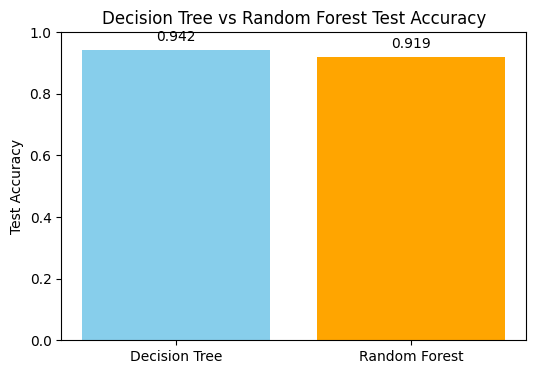

In [26]:
# Compare Decision Tree and Random Forest test accuracies
models = ['Decision Tree', 'Random Forest']
accuracies = [test_acc_dt, test_acc_rf]

plt.figure(figsize=(6,4))
bars = plt.bar(models, accuracies, color=['skyblue', 'orange'])
plt.ylim(0, 1)
plt.ylabel("Test Accuracy")
plt.title("Decision Tree vs Random Forest Test Accuracy")


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.02, f"{height:.3f}", ha='center', va='bottom')

plt.show()
